<a href="https://colab.research.google.com/github/sYasman/Abaqus_and_ML/blob/main/IntorductionToJax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jax Tutorial

In [ ]:
import jax
import jax.numpy as jnp

## Jax is similar to NumPy

In [ ]:
x = jnp.linspace(0, 10, num=100)

In [ ]:
x[:3]

DeviceArray([0.       , 0.1010101, 0.2020202], dtype=float32)

In [ ]:
# Can not assign new values like numpy !
# x[0] = -1

In [ ]:
from jax._src.api import block_until_ready
long_vector = jnp.arange(int(1e7))

%timeit jnp.dot(long_vector, long_vector).block_until_ready()

9.55 ms ± 123 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Grad

In [ ]:
def sum_of_squares(x):
  return jnp.sum(x**2)

In [ ]:
sum_of_squares_dx = jax.grad(sum_of_squares)
x = jnp.asarray([1., 2., 3., 4.])
print(sum_of_squares(x))
print(sum_of_squares_dx(x)) # df/dx

30.0
[2. 4. 6. 8.]


### Simple Newton-Raphson Example

In [ ]:
def f(x):
  return jnp.sinh(x**3 - 10)

x = 1.
diff = 1e3
iter_max = 100
iter_num = 1
TOL = 1e-3
while diff > TOL:
  df_dx = jax.grad(f)
  x = x - f(x)/df_dx(x)
  diff = jnp.abs(f(x))
  iter_num += 1
  if iter_num > iter_max:
    print('Did not converge')
    break
  if diff < TOL:
    print(f'Root is found after {iter_num} iterations')
    print(f'The root is {x}')

Root is found after 11 iterations
The root is 2.1544349193573


In [ ]:
def f(x, y):
  return x**2 + y**2

df_dx = jax.grad(f) # simply 2x ! Derivative w.r.t. only first variable ! -> If (x=1, y=2) -> df_dx = 2
df_dx(1.,2.)

df_dxdy = jax.grad(f, argnums=(0,1)) # derivative w.r.t both x and y -> df_dxy = [2x, 2y]
df_dxdy(1., 2.2)

(DeviceArray(2., dtype=float32, weak_type=True),
 DeviceArray(4.4, dtype=float32, weak_type=True))

In [ ]:
def g(x, y, z):
  return x**2 + y**2 + z**3

dg_dxdz = jax.grad(g, argnums=(0, 2)) #derivative w.r.t. x and z -> [2*x, 3*z**2]
dg_dxdz(1., 2., 1.)

(DeviceArray(2., dtype=float32, weak_type=True),
 DeviceArray(3., dtype=float32, weak_type=True))

In [ ]:
def sum_squared_error(x, y):
  return jnp.sum( (x-y)**2)

x = jnp.asarray([1., 2., 3., 4.])
y = jnp.asarray([1.1, 2.1, 3.1, 4.1])

print(sum_squared_error(x,y))
df_dx = jax.grad(sum_squared_error) # derivative w.r.t. x --> 2(x-y)
print(df_dx(x, y))

0.039999947
[-0.20000005 -0.19999981 -0.19999981 -0.19999981]


In [ ]:
jax.value_and_grad(sum_squared_error, argnums=(0, 1))(x, y) # derivatives w.r.t x and y. Then evalute the derivative w.r.t. x at x,y

(DeviceArray(0.03999995, dtype=float32),
 (DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
  DeviceArray([0.20000005, 0.19999981, 0.19999981, 0.19999981], dtype=float32)))

In [ ]:
# to return more than one result
def sum_squared_error(x, y):
  return jnp.sum( (x-y)**2)

def f_with_aux(x, y):
  return sum_squared_error(x, y), x-y

# jax.grad(f_with_aux)(x, y) # error.
jax.grad(f_with_aux, has_aux=True)(x, y) # returns (output, auxilary_data)

(DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 DeviceArray([-0.10000002, -0.0999999 , -0.0999999 , -0.0999999 ], dtype=float32))

### Assign new values to JAX vectors (or matrix of course AMK)

In [ ]:
x = jnp.array([1., 2., 3.])

print(f'Before change: {x}')

x = x.at[0].set(123)
print(f'After change: {x}')


def set_el(x, i, val):
  return x.at[i].set(val)

x = set_el(x, 0, 0)
print(f'After fucntion call x: {x}')

Before change: [1. 2. 3.]
After change: [123.   2.   3.]
After fucntion call x: [0. 2. 3.]


## Simple Training loop for linear regression

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
xs = np.random.normal(size=(100, ))
noise = np.random.normal(scale=0.100, size=(100, ))
ys = xs*3 * 1 + noise

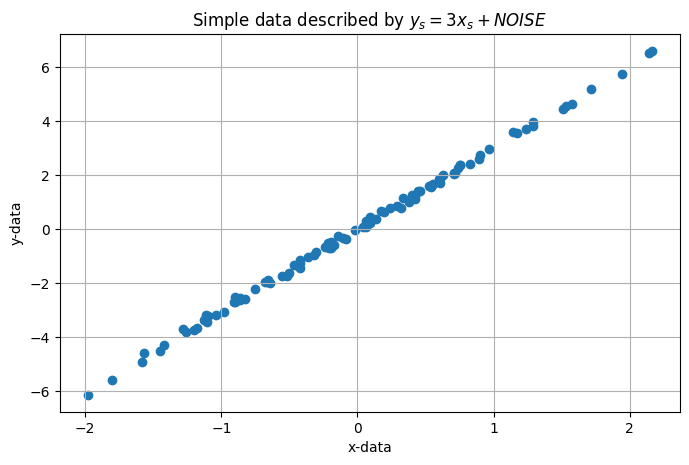

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)
ax.scatter(xs, ys)
ax.set_xlabel('x-data')
ax.set_ylabel('y-data')
ax.set_title('Simple data described by $y_s = 3x_s + NOISE$')
ax.grid()


In [ ]:
# model is y_pred = wx + b
def model(theta, x):
  w, b = theta
  return w*x + b

# define loss function as mean squared error :=  mean(y_pred - y)^2
def loss_fn(theta, x, y):
  y_pred = model(theta, x)
  return jnp.mean( (y_pred-y)**2)

In [ ]:
# add one step of NR
# theta_new = theta_n - lr* d(loss)/d(theta) # derivative w.r.t. trainable variables
def update(theta, x, y, lr=0.10):
  return theta - lr * jax.grad(loss_fn)(theta, x, y)

In [ ]:
theta = jnp.array([1., 1.])

for _ in range(1000):
  theta = update(theta, xs, ys)

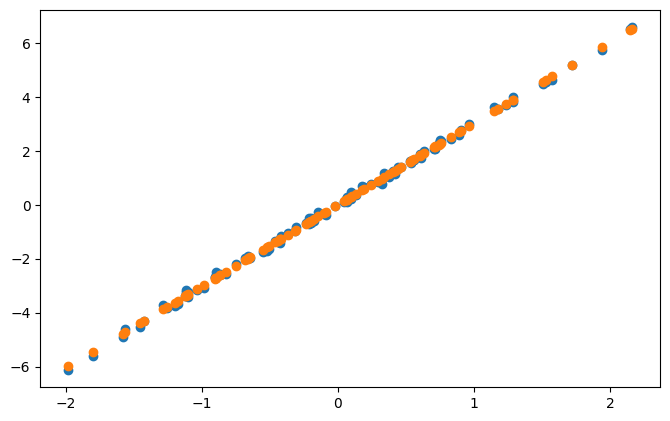

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)
ax.scatter(xs, ys)
ax.scatter(xs, model(theta, xs))

In [ ]:
theta

DeviceArray([3.0240538e+00, 9.4685022e-04], dtype=float32)

## Newton Raphson with multiple variables
$\begin{equation}
\begin{aligned}
x + y + z &= 3\\
x^2 + y^2 + z^2 &= 5\\
e^x + xy - xz &= 1
\end{aligned}
\end{equation}$

In [ ]:
@jax.jit
def eq(x):
  return jnp.asarray(
      [x[0] + x[1] + x[2] - 3., 
       x[0]**2 + x[1]**2 + x[2]**2 - 5., 
       jnp.exp(x[0])+x[0]*x[1]-x[0]*x[2] - 1]
  )

iter_max = 10000
TOL = 1e-6
DIFF = 10.
NORMS = []
x = jnp.array([-1., 0., 0.])
alpha = 1e-2
for iter_ in range(iter_max):
  J = jax.jacobian(eq)(x)
  Y = eq(x)
  dX =jnp.linalg.solve(J, Y)
  x = x - alpha * dX
  nrm = jnp.linalg.norm(eq(x))
  NORMS.append(nrm)
  if nrm < TOL:
    print(f'Converged after {iter_} iterations.')
    print(f'Residual: {nrm:.9f}')
    print(f'X: {x}')
    break
  # print(x,nrm)

Converged after 1495 iterations.
Residual: 0.000000970
X: [-2.7817852e-04  1.0005549e+00  1.9997224e+00]


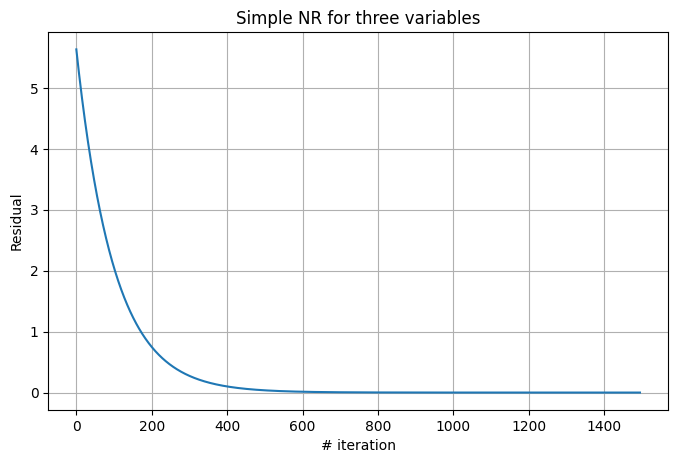

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)
ax.plot(NORMS)
ax.set_xlabel('# iteration')
ax.set_ylabel('Residual')
ax.set_title('Simple NR for three variables')
ax.grid()

## Just In Time Complier

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def selu(x, alpha=1.67, lambda_=1.05):
  return lambda_ * jnp.where(x > 0, x, alpha*jnp.exp(x) - alpha)

x = jnp.arange(1_000_000)
%timeit selu(x).block_until_ready()

selu_jit = jax.jit(selu)

selu_jit(x).block_until_ready()

%timeit selu_jit(x).block_until_ready

3.67 ms ± 158 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.42 ms ± 259 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
